**BfPortf 02 Custom target function**

This example shows how to use [bffortf](https://github.com/answering007/bfportf) to find portfolios using custom target function. [QuantStats](https://github.com/ranaroussi/quantstats) is used for reporting

In [1]:
# Import section
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.precision', 3)

from bfportf.utils import scale_return_data, get_portfolio_return, calculate_metric
from bfportf.optimization import find_portfolios
from bfportf.targets import pnl_target, sharpe_target, sortino_target

import quantstats as qs

In [2]:
# Load data
prices = pd.read_csv("https://raw.githubusercontent.com/answering007/bfportf/master/examples/prices.csv", index_col=0, parse_dates=['Date'])
returns = prices.pct_change()
returns.dropna(axis=0, inplace=True)
returns.head()

,AA,AAL,AAPL,ABBV,ABEV,ABT,ACB,ACWI,ADBE,ADI,...,XLU,XLV,XLY,XME,XOM,XOP,XPO,XRT,XRX,YUM
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.058,-5.564e-04,-2.817e-02,-0.019,-0.018,2.230e-04,0.0,-0.020,-0.005,-1.819e-02,...,-1.223e-02,-0.005,-0.019,-0.037,-0.027,-0.064,-0.031,-0.011,-0.022,-0.020
2015-01-06,0.007,-1.559e-02,9.408e-05,-0.005,0.038,-1.136e-02,0.0,-0.010,-0.020,-2.347e-02,...,6.400e-04,-0.003,-0.010,-0.014,-0.005,-0.030,-0.035,-0.011,-0.013,-0.012
2015-01-07,0.026,-5.660e-04,1.402e-02,0.040,0.017,8.108e-03,0.0,0.013,0.008,1.052e-02,...,9.811e-03,0.024,0.016,0.004,0.010,-0.010,0.004,0.026,0.013,0.033
2015-01-08,0.028,1.226e-02,3.842e-02,0.010,0.011,2.055e-02,0.0,0.016,0.025,1.765e-02,...,6.969e-03,0.017,0.015,0.010,0.017,0.034,0.006,0.013,0.028,0.017
2015-01-09,0.013,-3.056e-02,1.073e-03,-0.027,0.015,-1.051e-02,0.0,-0.006,-0.015,-7.305e-04,...,-6.292e-03,-0.009,-0.012,-0.002,-0.001,0.008,-0.013,-0.018,-0.006,-0.002


In [3]:
# Slit data to train and test
df_train, df_test = train_test_split(returns, test_size=0.2, shuffle=False)
print(f'Train shape: {df_train.shape}, Test shape: {df_test.shape}')
print(f'Train start: {str(df_train.index[0])}, end: {str(df_train.index[-1])}')
print(f'Test start: {str(df_test.index[0])}, end: {str(df_test.index[-1])}')

Train shape: (1691, 500), Test shape: (423, 500)
Train start: 2015-01-05 00:00:00, end: 2021-09-21 00:00:00
Test start: 2021-09-22 00:00:00, end: 2023-05-26 00:00:00


In [4]:
# Scale returns
df_train_scaled, train_weights = scale_return_data(df_train)
df_test_scaled, test_weights = scale_return_data(df_test)

In [5]:
# Custom target function to balance mean and standard deviation
def mean_std_param_target(returns: np.ndarray, exp: np.float64 = 1.0) -> np.float64:
    """Mean and standard deviation target function

    Args:
        returns (np.ndarray): 1d array of returns
        exp (np.float64, optional): Balancing factor. Higher values increase mean and decrease standard deviation and vice versa. Defaults to 1.0.

    Returns:
        np.float64: Target function value
    """
    return (1 + returns.mean())**(exp) / (1 + returns.std())**(1/exp)

In [6]:
# Run brute force search
found_portfolios = find_portfolios(
    returns=df_train_scaled,
    target_function=lambda x: mean_std_param_target(returns=x, exp=3.0),
    maximize=True,
    custom_weights=train_weights,
    max_number=3,
    verbose=True
)
found_portfolios.head()

100%|██████████| 500/500 [01:01<00:00,  8.16it/s]


,symbols,target_function_value
0,"[CPRT, IEF, NVDA]",1.0
1,"[CPRT, GOVT, NVDA]",1.0
2,"[CPRT, NVDA, SHY]",1.0
3,"[AMZN, NVDA, SHY]",1.0
4,"[DHR, NVDA, SHY]",1.0


In [7]:
# Add metrics to brute force results
found_portfolios["PnL"] = calculate_metric(found_portfolios, df_train_scaled, train_weights, pnl_target)
found_portfolios["Sharpe"] = calculate_metric(found_portfolios, df_train_scaled, train_weights, sharpe_target)
found_portfolios["Sortino"] = calculate_metric(found_portfolios, df_train_scaled, train_weights, sortino_target)
found_portfolios.head()

,symbols,target_function_value,PnL,Sharpe,Sortino
0,"[CPRT, IEF, NVDA]",1.0,1.624,1.941,2.989
1,"[CPRT, GOVT, NVDA]",1.0,1.202,1.954,3.015
2,"[CPRT, NVDA, SHY]",1.0,0.301,2.352,3.778
3,"[AMZN, NVDA, SHY]",1.0,0.303,2.323,3.709
4,"[DHR, NVDA, SHY]",1.0,0.292,2.310,3.709


In [8]:
# Select best portfolio symbols
selected_portfolio_symbols = found_portfolios['symbols'][0]

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2015-01-05   2015-01-05
End Period                 2021-09-21   2021-09-21
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          139.61%      162.37%
CAGR﹪                     9.4%         10.43%

Sharpe                     0.82         1.94
Prob. Sharpe Ratio         98.11%       100.0%
Smart Sharpe               0.82         1.93
Sortino                    1.14         2.99
Smart Sortino              1.13         2.97
Sortino/√2                 0.8          2.11
Smart Sortino/√2           0.8          2.1
Omega                      1.41         1.41

Max Drawdown               -33.72%      -10.84%
Longest DD Days            270          217
Volatility (ann.)          17.81%       7.55%
R^2                        0.29         0.29
Information Ratio          0.0          0.0
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-09-05,2018-12-24,2019-03-29,206,-10.836,-10.515
2,2020-02-20,2020-03-18,2020-04-16,57,-8.823,-8.300
3,2020-11-06,2021-03-08,2021-06-10,217,-8.325,-7.494
4,2015-04-16,2015-07-10,2015-10-02,170,-4.572,-4.492
5,2018-01-29,2018-02-08,2018-03-05,36,-3.607,-2.967


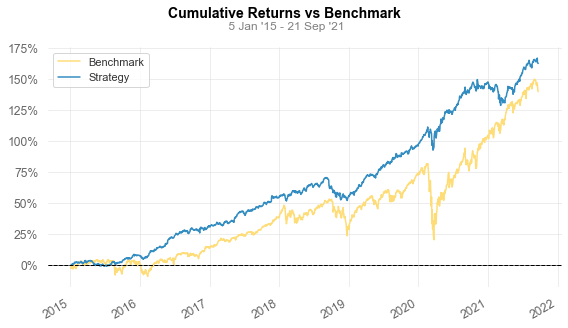

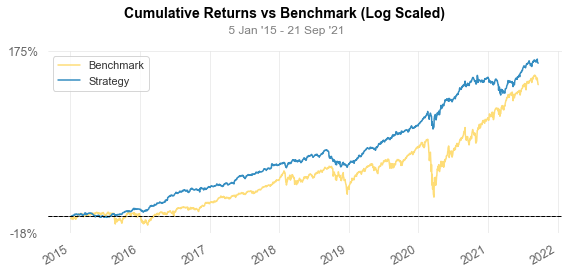

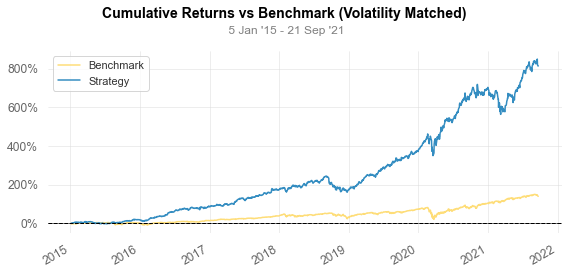

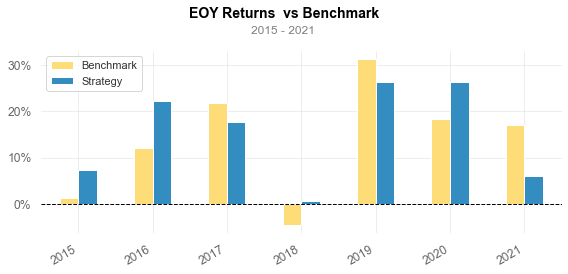

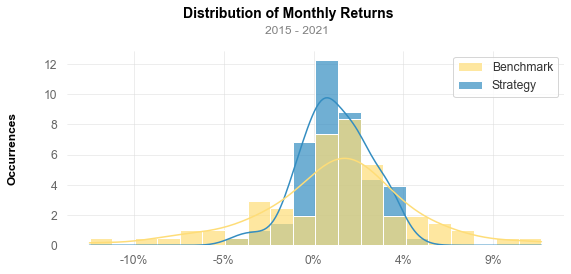

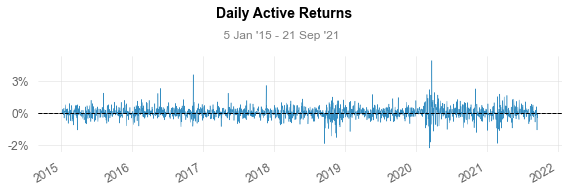

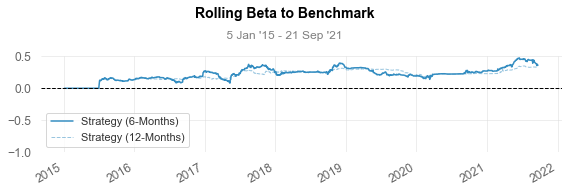

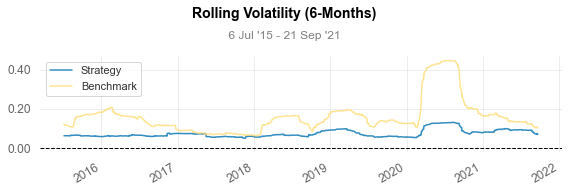

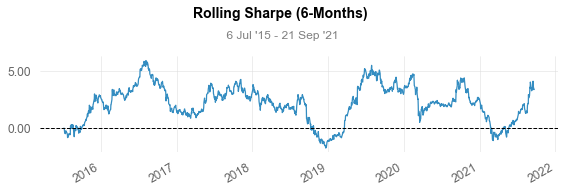

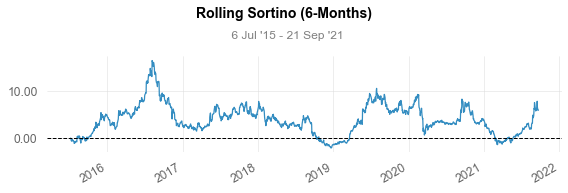

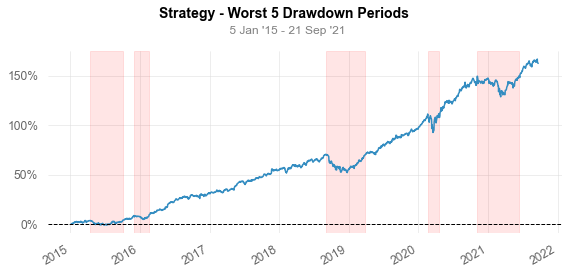

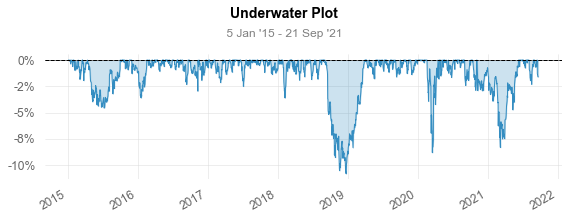

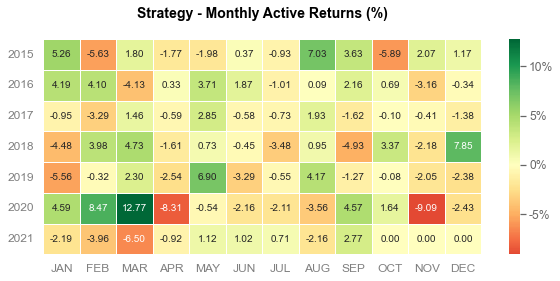

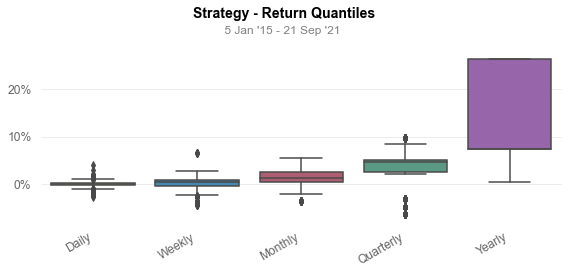

In [9]:
# In-sample results
portfolio_series = get_portfolio_return(
    returns=df_train_scaled,
    portfolio_symbols=selected_portfolio_symbols,
    return_weights=train_weights
)
benchmark_series = get_portfolio_return(
    returns=df_train_scaled,
    portfolio_symbols=['SPY'],
    return_weights=train_weights
)

qs.reports.full(portfolio_series, benchmark=benchmark_series, title='Portfolio Performance', show=True)

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2021-09-22   2021-09-22
End Period                 2023-05-26   2023-05-26
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          -0.3%        4.04%
CAGR﹪                     -0.12%       1.65%

Sharpe                     0.08         0.28
Prob. Sharpe Ratio         54.15%       63.93%
Smart Sharpe               0.08         0.27
Sortino                    0.11         0.4
Smart Sortino              0.11         0.4
Sortino/√2                 0.08         0.28
Smart Sortino/√2           0.08         0.28
Omega                      1.05         1.05

Max Drawdown               -21.36%      -19.25%
Longest DD Days            508          535
Volatility (ann.)          18.12%       10.61%
R^2                        0.57         0.57
Information Ratio          0.01         0.01
Calmar                 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-12-08,2022-10-14,2023-05-26,535,-19.250,-18.615
2,2021-09-23,2021-10-04,2021-10-22,30,-2.353,-2.260
3,2021-11-22,2021-11-23,2021-12-06,15,-1.278,-1.243
4,2021-11-10,2021-11-10,2021-11-18,9,-0.991,-0.871


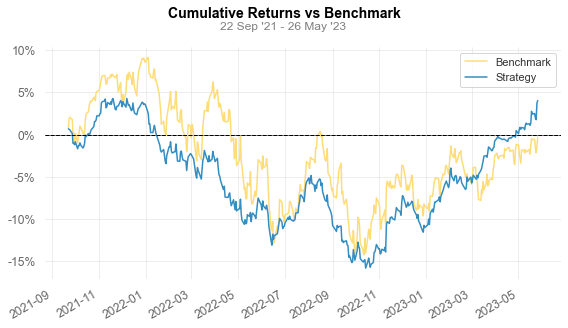

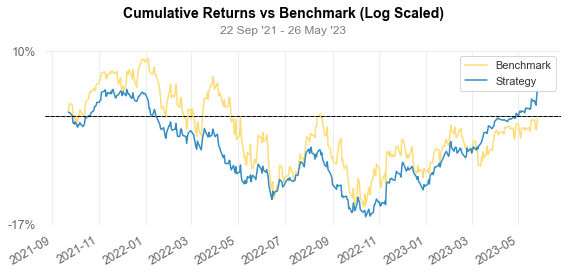

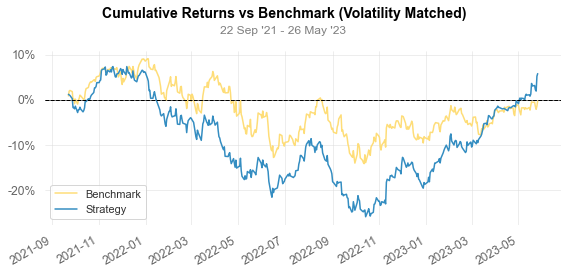

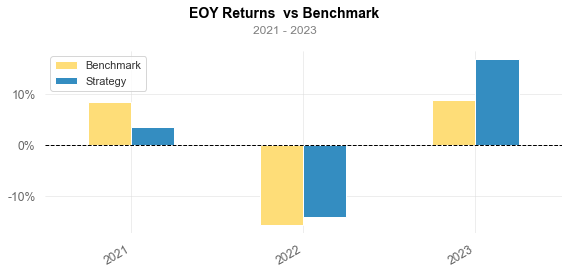

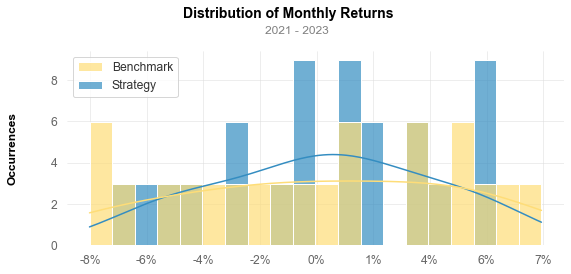

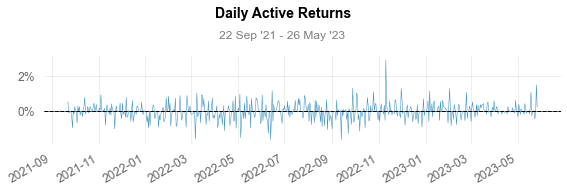

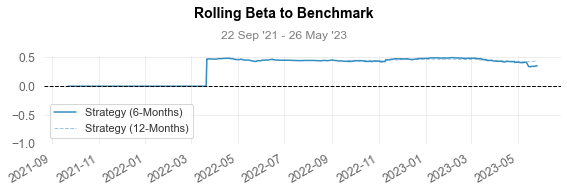

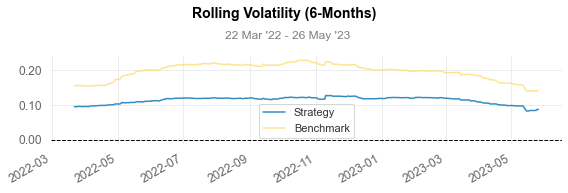

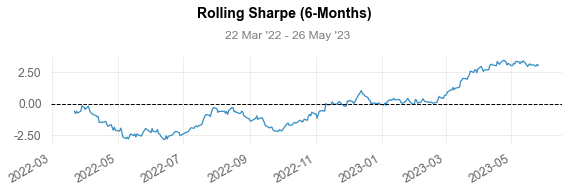

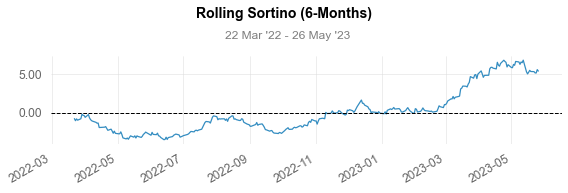

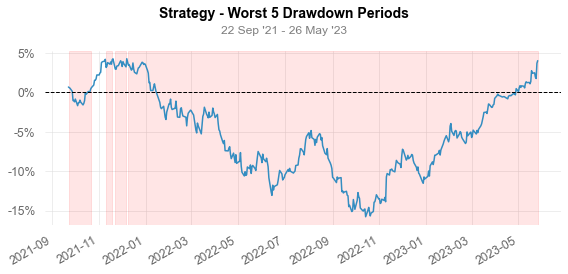

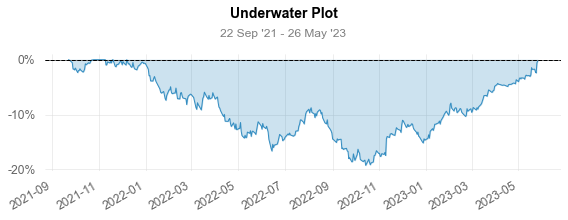

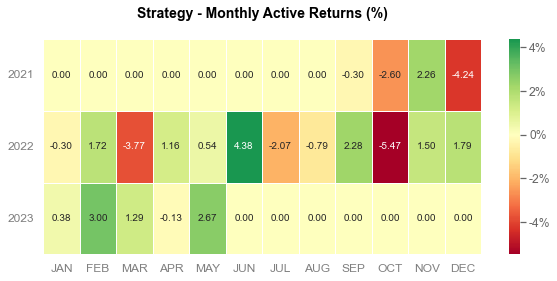

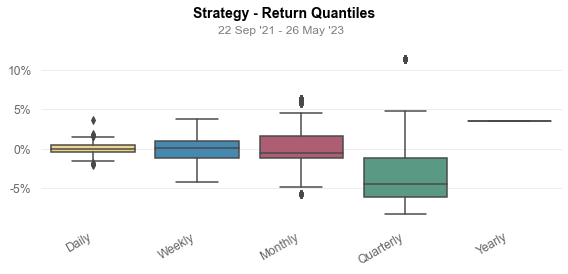

In [10]:
# Out-of-sample results
portfolio_series = get_portfolio_return(
    returns=df_test_scaled,
    portfolio_symbols=selected_portfolio_symbols,
    return_weights=train_weights
)
benchmark_series = get_portfolio_return(
    returns=df_test_scaled,
    portfolio_symbols=['SPY'],
    return_weights=train_weights
)

qs.reports.full(portfolio_series, benchmark=benchmark_series, title='Portfolio Performance', show=True)